# Explore Market Share Data to understand key patterns before modelling

In [10]:
import configparser
from pathlib import Path

import pandas as pd
import numpy as np

import time
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# define filepaths
config = configparser.ConfigParser()
config.read("config.ini")

# access values
raw_path = Path(config["default"]["raw_path"])
interim_path = Path(config["default"]["interim_path"])
processed_path = Path(config["default"]["processed_path"])

In [22]:
df = pd.read_csv(interim_path/"bev_market_share_data.csv")

df

,YEAR,BEV,PHEV,Country,BEV+PHEV
0,2008,NaN,NaN,Austria,NaN
1,2009,0.01,0.00,Austria,0.01
2,2010,0.03,0.00,Austria,0.03
3,2011,0.18,0.00,Austria,0.18
4,2012,0.13,0.08,Austria,0.21
...,...,...,...,...,...
589,2021,11.62,7.29,United Kingdom,18.91
590,2022,16.55,6.30,United Kingdom,22.85
591,2023,16.54,7.49,United Kingdom,24.03
592,2024,19.55,8.57,United Kingdom,28.12


In [ ]:
str()

First plot time series to get overall picture of how market share has changed in each country across entire time period

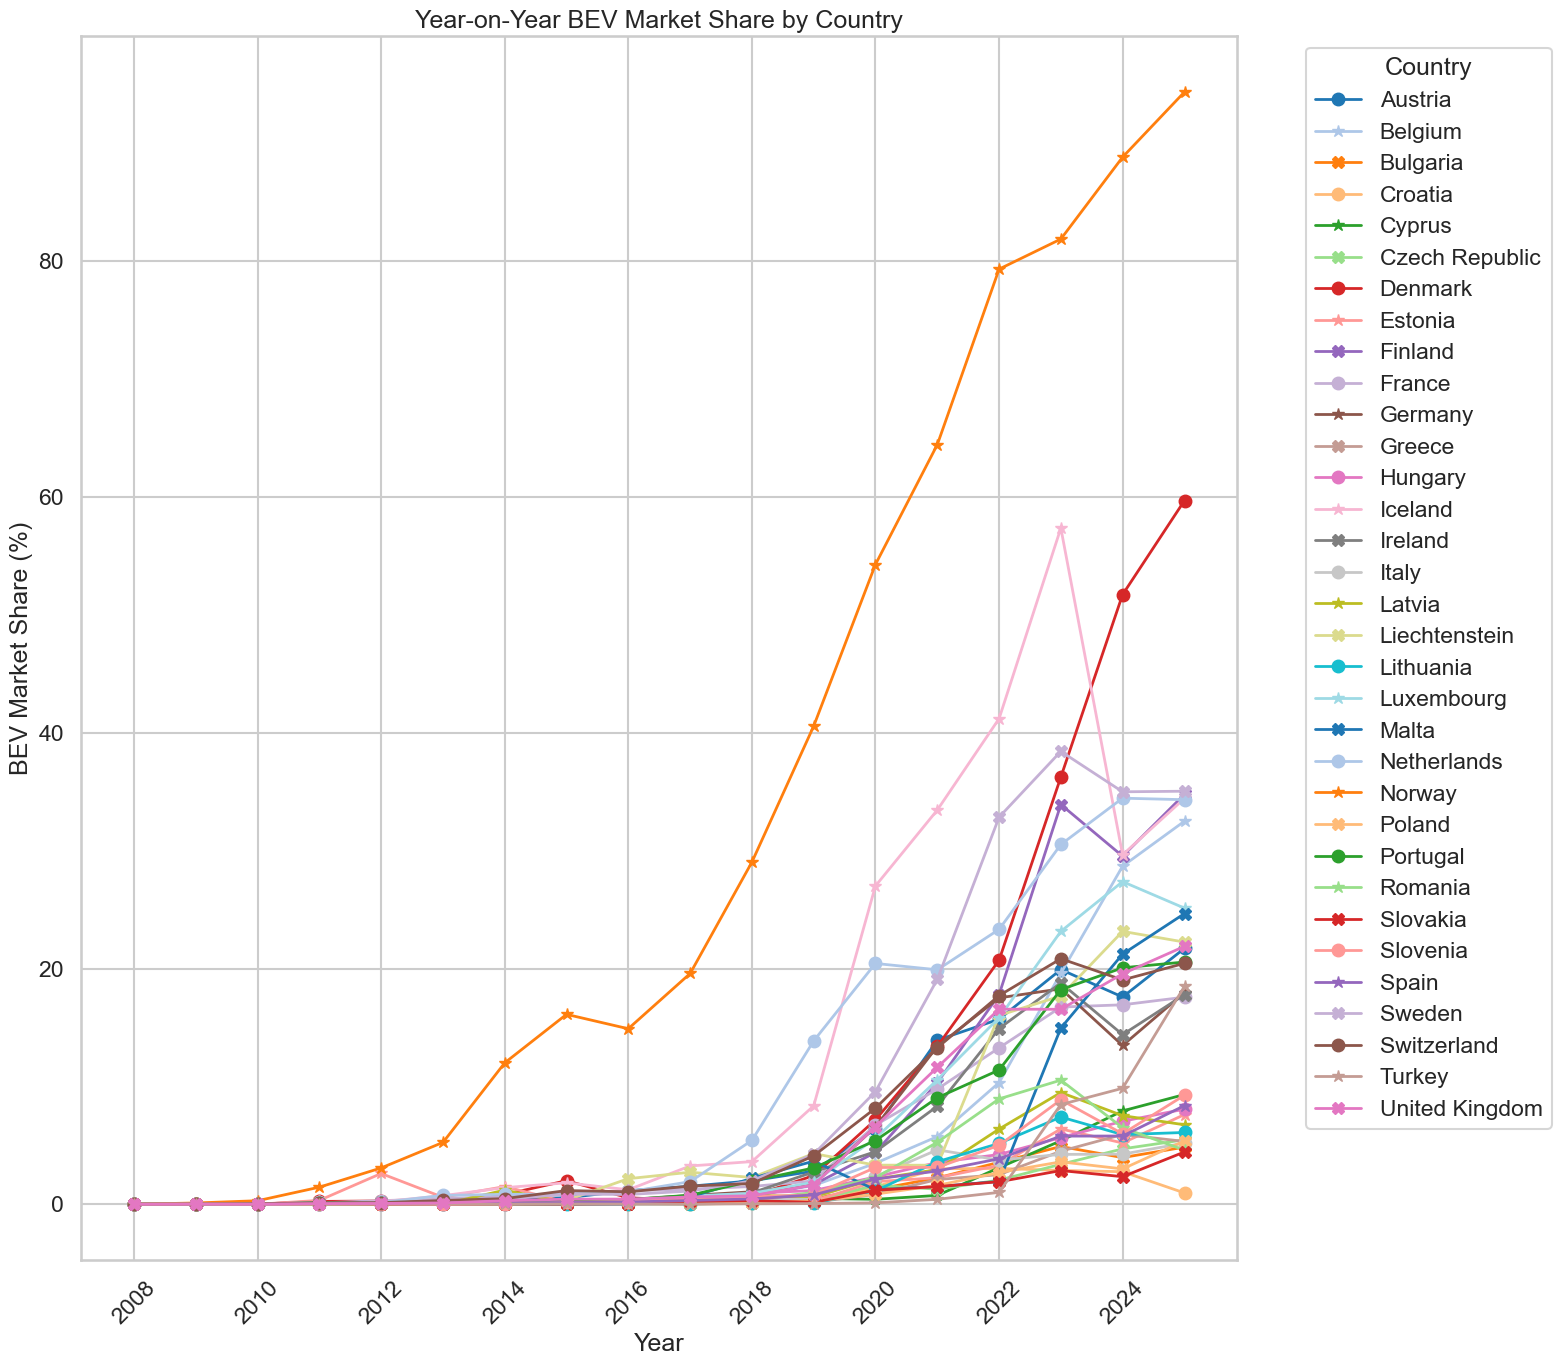

In [14]:
# replace NaN values with 0
df['BEV'] = df['BEV'].fillna(0)
df['YEAR'] = pd.to_datetime(df['YEAR'], format = '%Y')

# set seaborn style
sns.set_theme(style="whitegrid", palette="tab20", context="talk")
# set multiple marker symbols to allow differentiation between 33 lines
markers = itertools.cycle(['o', '*', 'X'])

# create figure
plt.figure(figsize=(16,14))

colours = sns.color_palette("tab20", n_colors=33)

# create a time series plot: year on x axis, BEV% market share on y, hue = country for distinct lines
# plot iteratively to loop through different marker types
for i, country in enumerate(df['Country'].unique()):
    country_data = df[df['Country'] == country]
    plt.plot(country_data['YEAR'], country_data['BEV'],
             label=country,
             marker=next(markers),
             linewidth=2,
             color=colours[i])
    
#sns.lineplot(data=df, x='YEAR', y='BEV', hue='Country', marker=next(markers), linewidth=2)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title='Country', ncol=1, frameon=True)

# axis labels and title
plt.xlabel("Year")
plt.ylabel("BEV Market Share (%)")
plt.title("Year-on-Year BEV Market Share by Country")

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

not nice looking at all but just about interpretable as a start point to get a general sense of the data...
- Norway = by far a trailblazer...has seen near explonential growth in BEV market share beginning with takeoff in 2010 - consistent year on year growth since 2016
- Denmark = second highest market share in 2024, following exponential takeoff in about 2019 - lag?
- Iceland too appeared to experience this exponential growth beginning in 2018, but something happended in 2023 and it plummeted?

In terms of potential groupings... [looking at 2024 data, as year 2025 incomplete is more vulnerable to potential noise from within year fluctuations]
- **Norway and Denmark** exist as trailblazing **outliers**
- **Sweden, Netherlands, Finland, Belgium** seem to form a relatively **'high'** uptake group (based on 2024)
- **Leitchenstein, Malta, Portugal, UK, Switzerland, France, Austria** at comparatively **'medium'** uptake rates
- **Slovakia, Croatia, Poland, Italy, Lithuania, Romania** at some of the **lowest**, and part of a broader apparent cluster with <10%> new registrations being BEVs in 2024

IF POLICY SEMANTICS ARE IMPORTANT DRIVERS/ STRONGLY LINKED TO YEARLY UPTAKE RATES, WE WOULD EXPECT TEXT EMBEDDING CLUSTERS TO BE SIMILAR TO THESE


#### lets quickly inspect how Plugin hybrids come into this - since they're also the subject of policy incentives.

,YEAR,Country,Type,MarketShare
0,2008,Austria,BEV,0.00
1,2009,Austria,BEV,0.01
2,2010,Austria,BEV,0.03
3,2011,Austria,BEV,0.18
4,2012,Austria,BEV,0.13
...,...,...,...,...
1777,2021,United Kingdom,BEV+PHEV,18.91
1778,2022,United Kingdom,BEV+PHEV,22.85
1779,2023,United Kingdom,BEV+PHEV,24.03
1780,2024,United Kingdom,BEV+PHEV,28.12


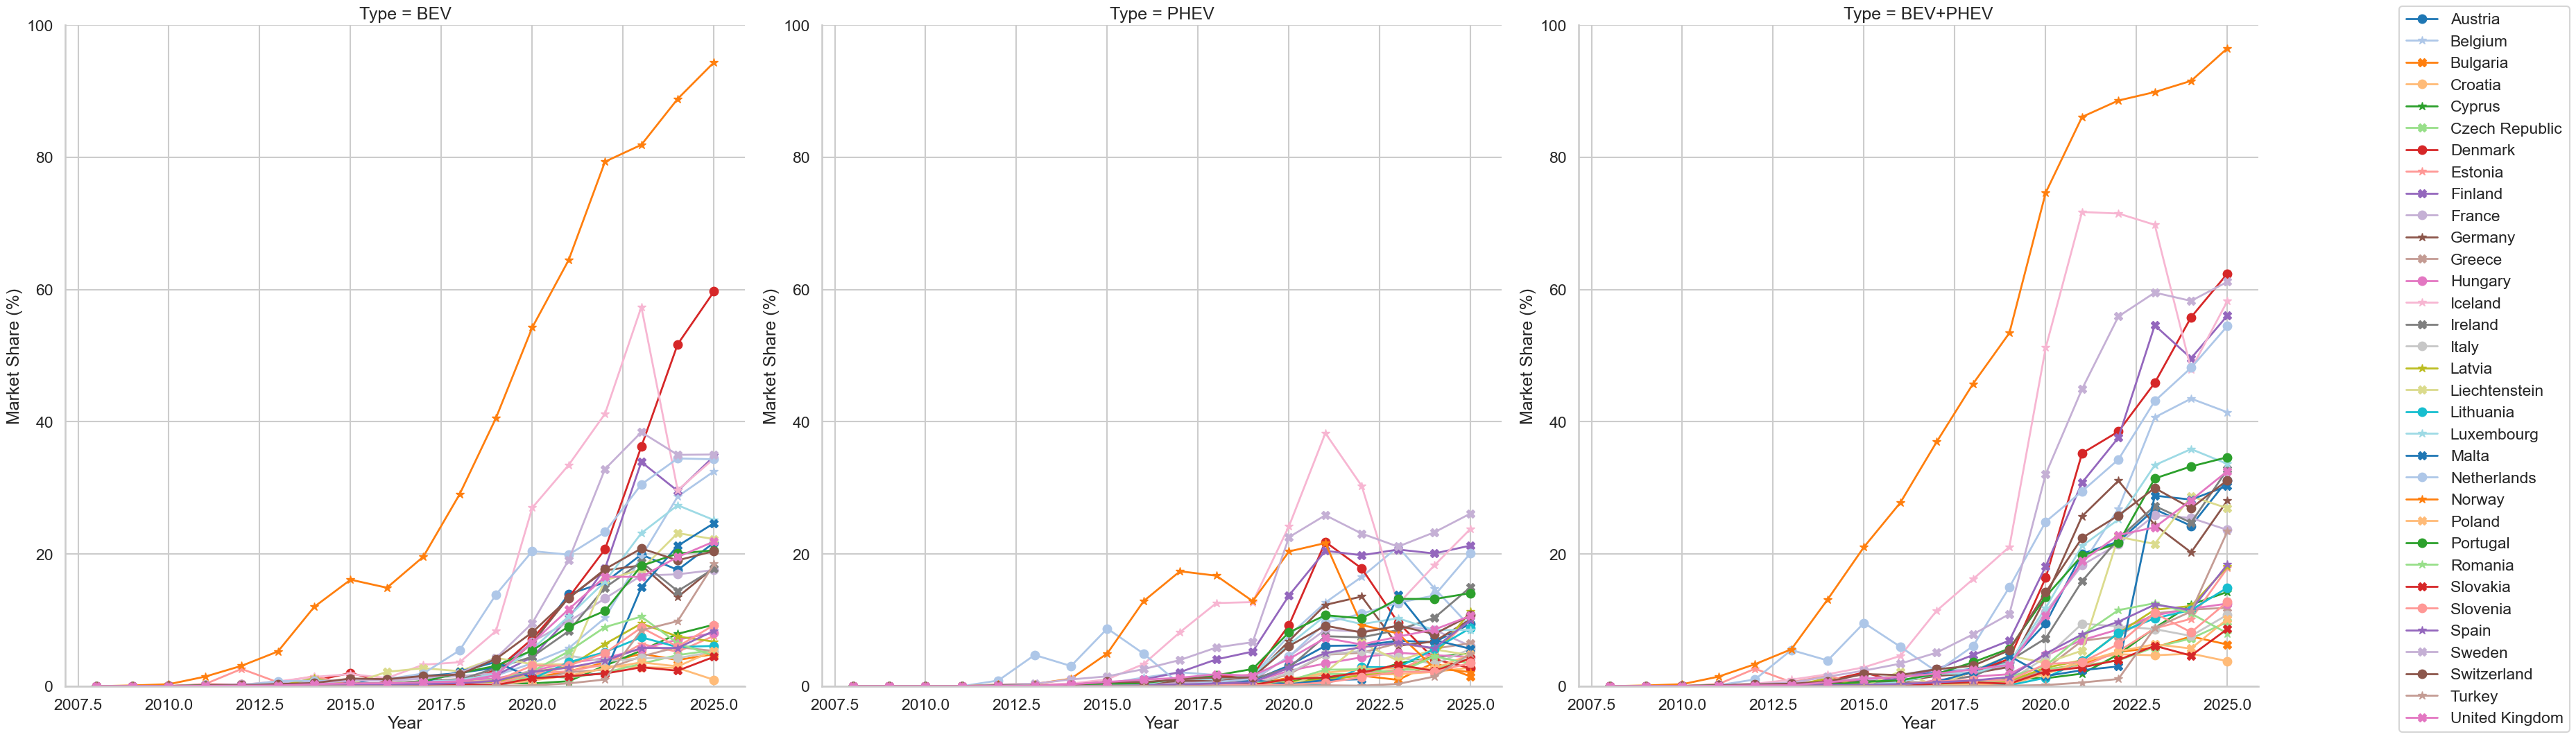

In [52]:
# 1. First convert df to long format (vehicle type becomes category rather than separate variable)
# replace Na values with 0 (these often come in 2008/ early years so safe to assume they likely correspond to low sales)
df[['BEV', 'PHEV', 'BEV+PHEV']] = df[['BEV', 'PHEV', 'BEV+PHEV']].fillna(0)

# Melt the dataframe: one column for 'Type' (BEV/PHEV/BEV+PHEV), one for Value
df_long = df.melt(
    id_vars=['YEAR', 'Country'],
    value_vars=['BEV', 'PHEV', 'BEV+PHEV'],
    var_name='Type',
    value_name='MarketShare'
)
df_long


# 2. Now plot metrics for vehicle types as side by side plots
sns.set_theme(style="whitegrid", palette="tab20", context="talk")

markers = itertools.cycle(['o', '*', 'X'])

# Facet grid by Type (BEV, PHEV, BEV+PHEV)
g = sns.FacetGrid(df_long, col='Type', col_wrap=3, height=11, sharey=False)

def plot_lines(data, **kwargs):
    ax = plt.gca()
    for country in data['Country'].unique():
        country_data = data[data['Country']==country]
        ax.plot(
            country_data['YEAR'], 
            country_data['MarketShare'],
            label=country,
            marker=next(markers),
            linewidth=2
        )
    ax.set_xlabel("Year")
    ax.set_ylabel("Market Share (%)")
    ax.set_ylim(0,100) # set consistent axis limits for visual comparison
    
    

g.map_dataframe(plot_lines)

# add shared legend for all subplots
handles, labels = g.axes[0].get_legend_handles_labels()
g.figure.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)
plt.tight_layout()
plt.show()


* Norway has very few PHEVs. No nation alone has a market share of greater than 30% for PHEVs, but considering them in addition to BEVs pushes far more countries beyond 20% threshold
* including them in combination with BEVs through doesnt drastically seem to change groupings
* will push ahead with BEVs as main focus of this analysis, as if the goal is zero emissions, BEVs have the potential to contribute towards this more strongly, but will keep these graphs in mind and see how a combined marketshare count might align more strongly with policy text? (this is likely, given that lots of EV policies cover PHEVs too)

## Summary statistics for 2024 BEV market share data
Lets write a quick function to help understand structure of the data for 2024 - by BEV, PHEV and BEV+PHEV
- histogram, boxplot, IQR, mean median mode etc...

In [26]:
# filter to 2024 data
df['YEAR'] = df['YEAR'].astype(int)
df_2024 = df[df['YEAR'] == 2024].copy()

df_2024.head()

,YEAR,BEV,PHEV,Country,BEV+PHEV
16,2024,17.58,6.67,Austria,24.25
34,2024,28.68,14.81,Belgium,43.49
52,2024,3.96,3.56,Bulgaria,7.52
70,2024,2.76,2.16,Croatia,4.92
88,2024,7.92,4.41,Cyprus,12.33


In [57]:
def summarise_annual_vehicle_type_ms(df, vehicle_type, year=2024, bins=10):
    """
    Summarise and visualise market share of a vehicle type for a given year.

    Args:
    df (pd.DataFrame): DataFrame containing 'YEAR', 'Country', and vehicle type columns
    vehicle_type (str): Column name to summarize ('BEV', 'PHEV', 'BEV+PHEV')
    year (int): Year to filter
    bins (int): Number of bins for histogram

    Returns:
    summary statistics (mean, median, Q1, Q3, IQR)
    histogram
    boxplot

    """ 
    # ensure year is numeric, then filter
    df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
    df_year = df[df['YEAR'] == year].copy()

    # replace any NaN with 0
    df_year[vehicle_type] = df_year[vehicle_type].fillna(0)
        
    # calculate summary stats
    mean_val = df_2024[vehicle_type].mean()
    median_val = df_2024[vehicle_type].median()
    Q1 = df_2024[vehicle_type].quantile(0.25)
    Q3 = df_2024[vehicle_type].quantile(0.75)
    IQR = Q3 - Q1

    stats ={
        'mean': mean_val,
        'median': median_val,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }

    print(f"Summary for {vehicle_type} % market share in {year} %")
    print(f"Mean: {mean_val} %")
    print(f"Median: {median_val}%")
    print(f"IQR: {IQR} ({Q3}:{Q1})")

    # side by side histogram and boxplots
    sns.set_theme(style="whitegrid", context="talk")
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # plot histogram with kde
    #plt.figure(figsize=(10,6))
    sns.histplot(df_2024[vehicle_type], bins=bins, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_xlabel(f"{vehicle_type} Market Share (%)")
    axes[0].set_ylabel("Number of Countries")
    axes[0].set_xlim(0, 100) 
    axes[0].set_ylim(0, 16) 
    axes[0].set_title(f"Distribution of {vehicle_type} Market Share Across Countries {year}")

    # plot boxplot
    sns.boxplot(df_2024[vehicle_type], orient='h', ax=axes[1])
    axes[1].set_xlabel(f"{vehicle_type} Market Share (%)")
    axes[1].set_title(f"Distribution of {vehicle_type} Market Share Across Countries {year}")
    axes[1].set_xlim(0, 100) 

    plt.tight_layout()
    plt.show()

    return stats


Summary for BEV % market share in 2024 %
Mean: 17.55151515151515 %
Median: 13.47%
IQR: 17.24 (23.15:5.91)


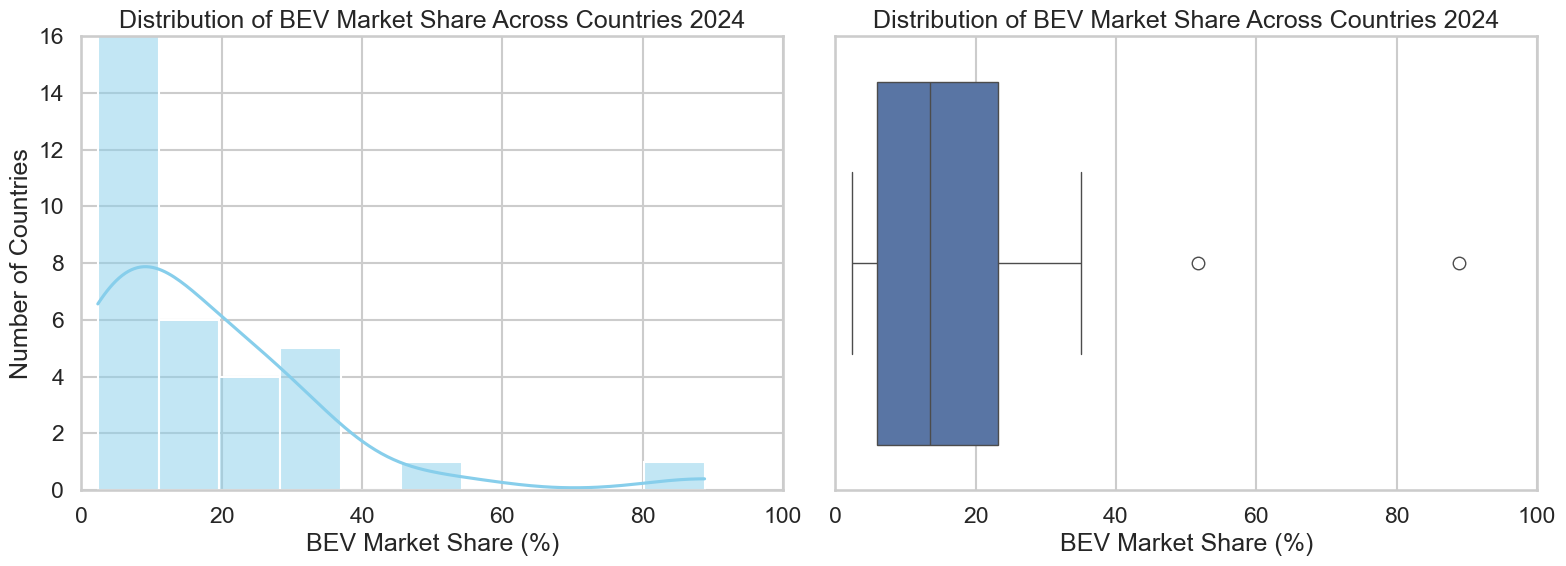

Summary for PHEV % market share in 2024 %
Mean: 7.283333333333333 %
Median: 5.6%
IQR: 4.959999999999999 (8.52:3.56)


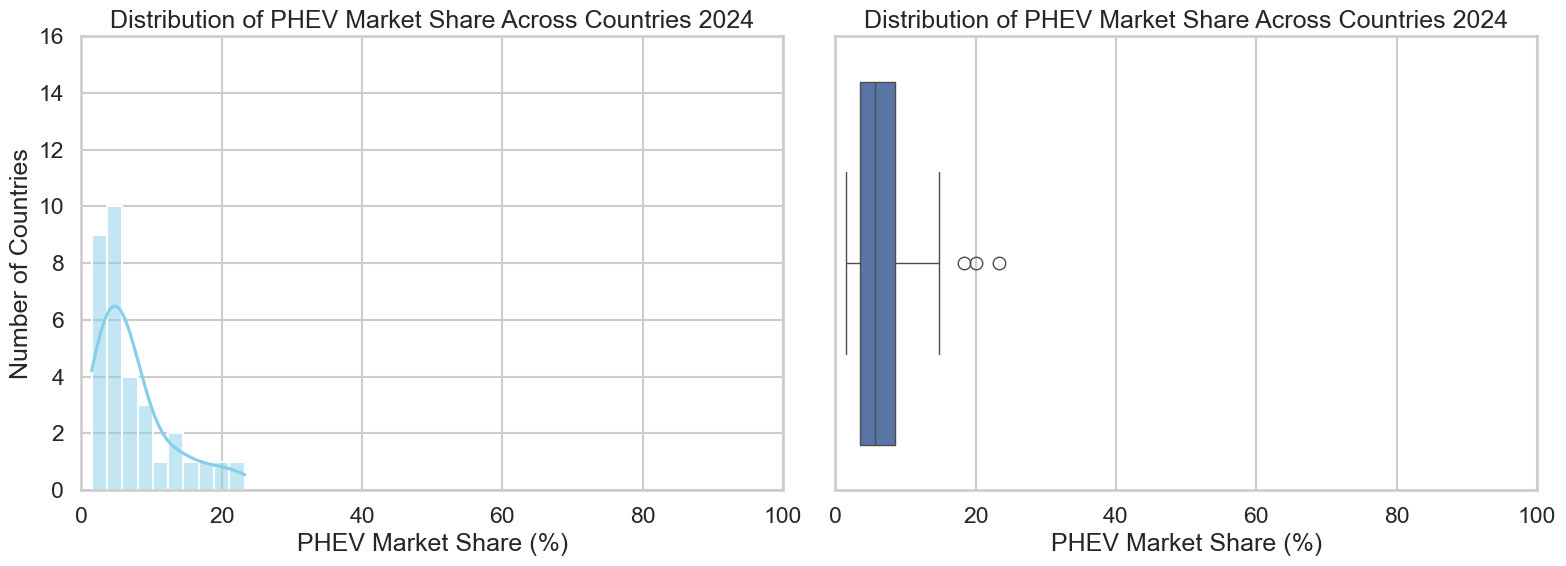

Summary for BEV+PHEV % market share in 2024 %
Mean: 24.834848484848482 %
Median: 20.24%
IQR: 22.249999999999993 (33.239999999999995:10.99)


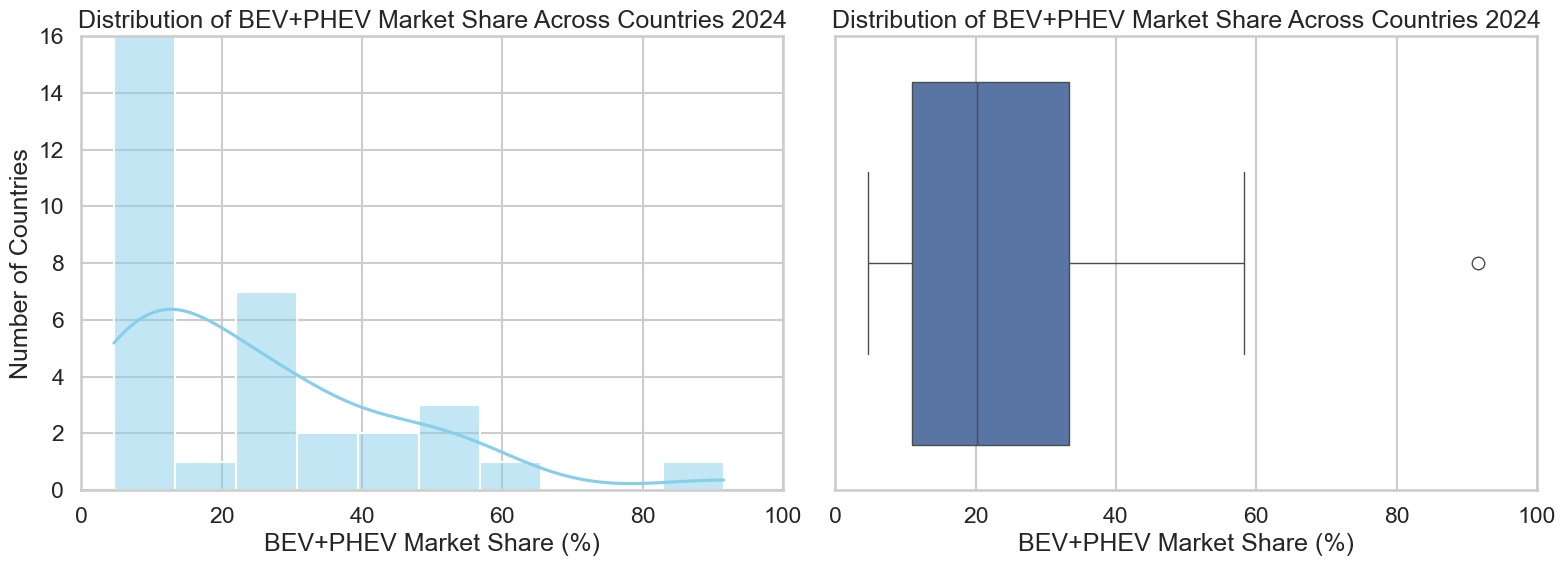

In [58]:
# For BEV
bev_stats = summarise_annual_vehicle_type_ms(df, "BEV", year=2024)

# For PHEV
phev_stats = summarise_annual_vehicle_type_ms(df, "PHEV", year=2024)

# For BEV+PHEV
bev_phev_stats = summarise_annual_vehicle_type_ms(df, "BEV+PHEV", year=2024)


-  confirming that average uptake remains well below 50% market share: almost half of countries have an uptake rate below 10%
- confirms Norway's position as huge outlier. Denmark sits at 50% - only other nation to reach majority threshold

## Assessing potential presence of regional patterns
- Lets map 2024 market share by country 